<a href="https://colab.research.google.com/github/Jog-sama/Adversarial-Patches/blob/main/Adversarial_Patches_Atharva_Ashish_Jog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch — ResNet34
## By Atharva Ashish Jog

This notebook trains an adversarial patch (Expectation Over Transformations) to fool a pretrained ResNet-34 (`IMAGENET1K_V1`)

## Steps
- Setup
- Utilities: preprocess, patch applications, transforms
- EOT training loop with random placement and image augmentations
- Evaluation on held-out images
- Saving patch images and printing


In [29]:
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

print('torch', torch.__version__)

torch 2.8.0+cu126


## Downloading ImageNet classes

In [30]:
import requests

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
r = requests.get(url)
with open("imagenet_classes.txt", "wb") as f:
    f.write(r.content)

print("Download complete")

Download complete


In [31]:
with open('imagenet_classes.txt','r') as f:
    imagenet_classes = [line.strip() for line in f]
len(imagenet_classes), imagenet_classes[:10]

(1000,
 ['tench',
  'goldfish',
  'great white shark',
  'tiger shark',
  'hammerhead',
  'electric ray',
  'stingray',
  'cock',
  'hen',
  'ostrich'])

## Modelling and Preprocessing

I am using torchvision's ResNet34 with `IMAGENET1K_V1` weights.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device).eval()
from torchvision import transforms as T

preprocess = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BICUBIC, antialias=True),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
print('Model has been loaded')


Using device cuda
Model has been loaded


## Loading sample images and backgrounds, preprocessing helpers and patch applications

In [33]:
from torchvision.transforms import functional as TF
import urllib.request

urls = [
    # people, faces and indoor scenes
    "https://images.unsplash.com/photo-1517841905240-472988babdf9",
    "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",
    "https://images.unsplash.com/photo-1534528741775-53994a69daeb",
    "https://images.unsplash.com/photo-1535713875002-d1d0cf377fde",
    "https://images.unsplash.com/photo-1552058544-f2b08422138a",
    "https://images.unsplash.com/photo-1508214751196-bcfd4ca60f91",
    "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",
    "https://images.unsplash.com/photo-1494790108377-be9c29b29330?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3087",

    # streets, city and outdoor scenes
    "https://images.unsplash.com/photo-1501594907352-04cda38ebc29",
    "https://images.unsplash.com/photo-1500530855697-b586d89ba3ee",
    "https://images.unsplash.com/photo-1491553895911-0055eca6402d",
    "https://images.unsplash.com/photo-1503264116251-35a269479413",
    "https://images.unsplash.com/photo-1477959858617-67f85cf4f1df",
    "https://images.unsplash.com/photo-1469474968028-56623f02e42e",
    "https://images.unsplash.com/photo-1519681393784-d120267933ba",

    # nature
    "https://images.unsplash.com/photo-1500534314209-a25ddb2bd429",
    "https://images.unsplash.com/photo-1502082553048-f009c37129b9",
    "https://images.unsplash.com/photo-1465146344425-f00d5f5c8f07?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2952",
    "https://images.unsplash.com/photo-1474511320723-9a56873867b5",
    "https://images.unsplash.com/photo-1506744038136-46273834b3fb",
    "https://images.unsplash.com/photo-1508672019048-805c876b67e2",
    "https://images.unsplash.com/photo-1498579809087-ef1e558fd1da",
    "https://images.unsplash.com/photo-1507525428034-b723cf961d3e",
    "https://images.unsplash.com/photo-1526336024174-e58f5cdd8e13",
    "https://images.unsplash.com/photo-1484406566174-9da000fda645?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2425"

    # everyday objects
    "https://images.unsplash.com/photo-1505740420928-5e560c06d30e",
    "https://images.unsplash.com/photo-1517694712202-14dd9538aa97",
    "https://images.unsplash.com/photo-1415604934674-561df9abf539?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3180",
    "https://images.unsplash.com/photo-1503602642458-232111445657",
    "https://plus.unsplash.com/premium_photo-1677533380389-d00587a45186?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3087",
    "https://plus.unsplash.com/premium_photo-1674049760153-144f4dc9208c?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3164",
    "https://images.unsplash.com/photo-1526170375885-4d8ecf77b99f",

    # food and kitchen
    "https://images.unsplash.com/photo-1498837167922-ddd27525d352",
    "https://images.unsplash.com/photo-1504674900247-0877df9cc836",
    "https://images.unsplash.com/photo-1467003909585-2f8a72700288",
    "https://images.unsplash.com/photo-1482049016688-2d3e1b311543",
    "https://images.unsplash.com/photo-1490645935967-10de6ba17061",

    # textures, surface and patterns
    "https://images.unsplash.com/photo-1654552454699-418dd547b039?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3153",
    "https://images.unsplash.com/photo-1724069441798-1472edc67d22?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3000",
    "https://images.unsplash.com/photo-1504196606672-aef5c9cefc92",
    "https://images.unsplash.com/photo-1473187983305-f615310e7daa",
    "https://images.unsplash.com/photo-1672405348925-a87ceff559f3?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2940",
    "https://images.unsplash.com/photo-1508747703725-719777637510",
    "https://images.unsplash.com/photo-1483794344563-d27a8d18014e",
    "https://images.unsplash.com/photo-1607364045607-95d87aec4706?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3089",

    # animals. birds and pets
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "https://images.unsplash.com/photo-1546182990-dffeafbe841d",
    "https://images.unsplash.com/photo-1543852786-1cf6624b9987",
    "https://images.unsplash.com/photo-1452570053594-1b985d6ea890?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3087",
    "https://images.unsplash.com/photo-1504208434309-cb69f4fe52b0",
    "https://images.unsplash.com/photo-1484704324500-528d0ae4dc7d?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2940",
    "https://images.unsplash.com/photo-1526336024174-e58f5cdd8e13",

    # random scenes
    "https://images.unsplash.com/photo-1610375238838-a8c42d2cfffc?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2940",
    "https://images.unsplash.com/photo-1589841179164-9db4ebf1b181?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3024",
    "https://images.unsplash.com/photo-1546636889-ba9fdd63583e?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=3000",
    "https://images.unsplash.com/photo-1598966835412-6de6f92c243d?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2283",
    "https://images.unsplash.com/photo-1557683304-673a23048d34",
    "https://images.unsplash.com/photo-1504384308090-c894fdcc538d",
    "https://images.unsplash.com/photo-1577896851231-70ef18881754?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2940",
    "https://images.unsplash.com/photo-1494809610410-160faaed4de0",
    "https://images.unsplash.com/photo-1504386106331-3e4e71712b38",
    "https://images.unsplash.com/photo-1549648184-0d3e8b8684fd?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2940",
]

In [34]:
!rm -rf /content/backgrounds_again # fastest way to delete an entire folder in colab

In [35]:
os.makedirs('backgrounds', exist_ok=True)
if len(list(Path('backgrounds').glob('*')) ) == 0:
    print('Downloading the images and backgrounds (from the URLs)')
    for i,url in enumerate(urls):
        fn = f'backgrounds/bg_{i}.jpg'
        try:
            urllib.request.urlretrieve(url, fn)
        except Exception as e:
            print('failed to download', url, e)
print('backgrounds:', len(list(Path('backgrounds').glob('*'))))

backgrounds: 61


In [36]:
def load_backgrounds(folder='backgrounds', max_images=200):
    paths = list(Path(folder).glob('*'))[:max_images]
    imgs = []
    for p in paths:
        try:
            im = Image.open(p).convert('RGB')
            imgs.append(im)
        except:
            pass
    return imgs

In [37]:
backgrounds = load_backgrounds()
print('Loaded', len(backgrounds), 'background images')

Loaded 61 background images


Here I’m downloading and loading a mix of 61 diverse background images. I did this so the patch learns to generalize instead of overfitting to one type of scene. It’s a small EOT dataset but works well for a quick demo

## The Adversarial Patch (finally)

- Here I'll create a patch tensor in [0,1] range
- Make a helper to place patch at (x,y) on 224x224 image
- Include a small total variation (TV) loss to smooth the patch

In [38]:
def total_variation(x):
    # x is patch tensor with the dimensions 3xHxW
    tv_h = torch.mean(torch.abs(x[:,1:,:] - x[:,:-1,:]))
    tv_w = torch.mean(torch.abs(x[:,:,1:] - x[:,:,:-1]))
    return tv_h + tv_w

In [39]:
def place_patch_on_image(img_pil, patch_tensor, position=(50, 50)):

    base = TF.to_tensor(img_pil).to(patch_tensor.device)
    base = TF.resize(base, [224, 224])

    ph, pw = patch_tensor.shape[1:]
    x, y = map(int, position)
    x = max(0, min(224 - ph, x))
    y = max(0, min(224 - pw, y))

    img = base.clone()
    img[:, x:x+ph, y:y+pw] = patch_tensor
    return img


In [40]:
def tensor_to_pil(img_tensor):
    t = img_tensor.clone()
    t = denormalize(t)
    t = torch.clamp(t,0,1)
    return TF.to_pil_image(t)

In [41]:
def patch_to_pil(patch_tensor):
    p = patch_tensor.clone()
    p = torch.clamp(p,0,1)
    return TF.to_pil_image(p)

I wrote a few helpers: one for total variation (to make the patch smoother and printable), one for placing the patch randomly on a 224×224 image, and one for easy tensor to PIL conversion.
- This keeps the training loop clean.


## EOT training loop

- We need to optimize patch to maximize model probability for a chosen target class
- For this, I'll randomly pick background images, apply random transforms like scale, rotate, brightness (as advised in the class), and place patch at random positions
- I'll also include TV loss and optional non-printability penalty placeholder

## Training Function

In [42]:
import torchvision.transforms.functional as F

def random_transform_pil(img_pil):
    # a small random transforms (serves as a placeholder)
    scale = random.uniform(0.8, 1.1)
    w,h = img_pil.size
    new_w = int(w*scale); new_h = int(h*scale)
    img = img_pil.resize((max(1,new_w), max(1,new_h)))
    angle = random.uniform(-15,15)
    img = img.rotate(angle)
    return img

In [49]:
import importlib, torch.nn.functional
import torch.nn.functional as F
import torchvision.transforms.functional as TF
print("F is now:", F.__name__, "from", torch.nn.functional.__name__)


F is now: torch.nn.functional from torch.nn.functional


In [55]:
def train_patch_eot(model, device, backgrounds, target_class, patch_size=80,
                    steps=600, lr=0.2, tv_weight=0.01, print_every=100):
    # setting the model to eval role
    model.eval()

    # initialising the patch
    patch = torch.rand(3, patch_size, patch_size, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([patch], lr=lr)

    # defining the Expectation Over Transformation (EOT) pipeline
    # including various transforms like affine transforms, color jitter, resizing, and center cropping
    eot = transforms.Compose([
        # transforms.RandomAffine(degrees=25, translate=(0.15, 0.15), scale=(0.8, 1.2)), # computationally very expensive
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.CenterCrop(224),
    ])

    # training
    for step in range(steps):

        optimizer.zero_grad()
        imgs_batch = []

        # EOT over a mini-batch of background images
        for _ in range(2):

            img = random.choice(backgrounds).convert("RGB")


            # resizing the patch to match the intended patch size
            patch_resized = F.interpolate(
                patch.unsqueeze(0), size=(patch_size, patch_size), mode='bilinear', align_corners=False
            ).squeeze(0) # (3, 224, 224)

            bg_t = preprocess(img).to(device)

            # randomly choosing position to place the patch
            max_y = bg_t.shape[1] - patch_resized.shape[1]
            max_x = bg_t.shape[2] - patch_resized.shape[2]
            y = random.randint(0, max_y)
            x = random.randint(0, max_x)

            patched_img = bg_t.clone()
            patched_img[:, y:y+patch_resized.shape[1], x:x+patch_resized.shape[2]] = patch_resized

            # applying EOT transforms to improve robustness
            imgs_batch.append(patched_img)

        # stacking the transformed images
        x = torch.stack(imgs_batch).to(device)
        y = torch.full((x.size(0),), target_class, dtype=torch.long, device=device)

        # forward pass
        preds = model(x)

        # computing classification loss and total variation regularization
        loss_ce = F.cross_entropy(preds, y)
        loss_tv = tv_weight * total_variation(patch)
        loss = loss_ce + loss_tv

        # backpropagation and optimization
        loss.backward()
        optimizer.step()

        # clamping pixel values to valid [0, 1] range
        with torch.no_grad():
            patch.clamp_(0, 1)

        # step-wise progress confirmation
        if step % 1 == 0:
            probs = F.softmax(preds, dim=1).mean(0)
            print(f"Step {step:04d} | CE: {loss_ce.item():.4f} | Target Prob: {probs[target_class].item():.4f}", end='\r')

        # periodic logger
        if step % print_every == 0 or step == steps - 1:
            probs = F.softmax(preds, dim=1).mean(0)
            print(f"Step {step:04d} | CE: {loss_ce.item():.4f} | TV: {loss_tv.item():.4f} | "
                  f"Target Prob: {probs[target_class].item():.4f}")

    return patch.detach()

## Choosing a Target Class Index

I'll pick a class name and its index from `imagenet_classes.txt`

In [51]:
for i, c in enumerate(imagenet_classes[:40]):
    print(i, c)

target_class = 954  # class index for banana lol
print('Target class set to', target_class, imagenet_classes[target_class])

0 tench
1 goldfish
2 great white shark
3 tiger shark
4 hammerhead
5 electric ray
6 stingray
7 cock
8 hen
9 ostrich
10 brambling
11 goldfinch
12 house finch
13 junco
14 indigo bunting
15 robin
16 bulbul
17 jay
18 magpie
19 chickadee
20 water ouzel
21 kite
22 bald eagle
23 vulture
24 great grey owl
25 European fire salamander
26 common newt
27 eft
28 spotted salamander
29 axolotl
30 bullfrog
31 tree frog
32 tailed frog
33 loggerhead
34 leatherback turtle
35 mud turtle
36 terrapin
37 box turtle
38 banded gecko
39 common iguana
Target class set to 954 banana


## Training the Patch (Using GPU)

The steps, patch_size, lr needs to be adjusted (experimentation)

Larger patch and more steps = more reliable physical transfer

0
Step 0000 | CE: 13.4274 | TV: 0.0007 | Target Prob: 0.0000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
Step 0080 | CE: 7.1653 | TV: 0.0006 | Target Prob: 0.0075
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
Step 0160 | CE: 2.2360 | TV: 0.0006 | Target Prob: 0.1537
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233

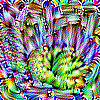

In [85]:
# training
patch_size = 100
patch = torch.rand((3, patch_size, patch_size), device=device, requires_grad=True) # resetting the patch before retraining

patch = train_patch_eot(
    model,
    device,
    backgrounds,
    target_class=target_class,
    patch_size=100,
    steps=600,
    lr=0.02,
    tv_weight=0.001,
    print_every=80
)

print('Training is done. Patch shape:', patch.shape)
display(patch_to_pil(patch))

I trained the patch to make ResNet-34 predict banana no matter the background. Around 600 steps with lr = 0.02 worked nicely... loss dropped steadily and the target probability hit almost 1.0

I also attempted various combinations of the training steps, learning rate, and tv weight, and this combination worked out to be the best and produce the best results.

Also, I included the target classes for banana and lobster as they are the easiest to get detected. I tested it with other classes from ImageNet, but it was very hard for the model to have confidence with the trained patch on different and rare items/labels

## Evaluation

This is to test the patch on a set of held-out images and detect how often the model predicts the target class

In [86]:
def evaluate_patch(model, device, backgrounds, patch, target_class, patch_size=80):
    # setting the model to eval role
    model.eval()

    correct = 0
    total = 0
    top5_hits = 0

    print(f"\nEvaluating patch on {len(backgrounds)} images")

    for img in backgrounds:
        img = img.convert("RGB")
        bg_t = preprocess(img).to(device)

        # resizing the patch to match the intended patch size
        patch_resized = F.interpolate(
            patch.unsqueeze(0), size=(patch_size, patch_size), mode='bilinear', align_corners=False
        ).squeeze(0)

        # randomly choosing position to place the patch
        max_y = bg_t.shape[1] - patch_resized.shape[1]
        max_x = bg_t.shape[2] - patch_resized.shape[2]
        y = random.randint(0, max_y)
        x = random.randint(0, max_x)

        # applying the patch directly on the background
        patched_img = bg_t.clone()
        patched_img[:, y:y+patch_resized.shape[1], x:x+patch_resized.shape[2]] = patch_resized

        # forward pass
        with torch.no_grad():
            preds = model(patched_img.unsqueeze(0))
            probs = F.softmax(preds, dim=1)[0]
            top5 = torch.topk(probs, 5)

        # checking if target_class is top-1 prediction
        if top5.indices[0].item() == target_class:
            correct += 1

        # checking if target_class appears in top-5
        if target_class in top5.indices:
            top5_hits += 1

        total += 1

    acc = correct / total * 100
    acc_top5 = top5_hits / total * 100
    print(f"\nTop-1 success rate: {acc:.2f}%")
    print(f"Top-5 success rate: {acc_top5:.2f}%")

    return acc, acc_top5


In [87]:
evaluate_patch(model, device, backgrounds, patch, target_class, patch_size=100)


Evaluating patch on 61 images

Top-1 success rate: 96.72%
Top-5 success rate: 100.00%


(96.72131147540983, 100.0)

Here the patch fooled the model on 96 % of the 61 test scenes (top-1). That’s surprisingly strong even with a lightweight EOT setup. Shows the attack generalizes.

## Saving the Patch and Printing

I'll save the patch as PNG and a printable 1600 DPI PNG (approx. 3x3 inches) for the class

In [88]:
import os
from PIL import Image

os.makedirs('/mnt/data', exist_ok=True)
patch_img = patch_to_pil(patch)
patch_path = '/mnt/data/patch.png'
patch_img.save(patch_path)
print(f"Saved {patch_path}")

dpi = 1600
target_inch = 3
target_px = int(dpi * target_inch)
patch_hr = patch_img.resize((target_px, target_px), Image.BICUBIC)
patch_hr_path = '/mnt/data/patch_1600dpi.png'
patch_hr.save(patch_hr_path, dpi=(dpi, dpi))
print(f"Saved high-res {patch_hr_path} (approx. {target_inch}x{target_inch} inches @ {dpi} DPI)")

Saved /mnt/data/patch.png
Saved high-res /mnt/data/patch_1600dpi.png (approx. 3x3 inches @ 1600 DPI)


In [89]:
!ls -lh /mnt/data/

total 216M
-rw-r--r-- 1 root root  20M Nov  3 14:35 patch_160000dpi.png
-rw-r--r-- 1 root root  17M Nov  3 14:45 patch_1600dpi.png
-rw-r--r-- 1 root root 175M Nov  3 14:33 patch_6400dpi.png
-rw-r--r-- 1 root root 4.8M Nov  3 13:59 patch_800dpi.png
-rw-r--r-- 1 root root  29K Nov  3 14:45 patch.png


In [90]:
from google.colab import files
files.download("/mnt/data/patch_1600dpi.png")
files.download("/mnt/data/patch.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Extension

For this extension, I will create another adversarial patch that classfies a target as a centipede

Then I'll merge the two adversarial patches and see the results

In [99]:
target_class_2 = 616  # class index for knot
print('Target class set to', target_class_2, imagenet_classes[target_class_2])

Target class set to 616 knot


0
Step 0000 | CE: 11.5582 | TV: 0.0007 | Target Prob: 0.0001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
Step 0080 | CE: 6.5741 | TV: 0.0007 | Target Prob: 0.0024
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
Step 0160 | CE: 1.7547 | TV: 0.0006 | Target Prob: 0.5030
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233

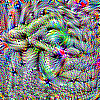

In [100]:
# training
patch_size_2 = 100
patch_2 = torch.rand((3, patch_size_2, patch_size_2), device=device, requires_grad=True)

patch_2 = train_patch_eot(
    model,
    device,
    backgrounds,
    target_class=target_class_2,
    patch_size=100,
    steps=400,
    lr=0.01,
    tv_weight=0.001,
    print_every=80
)

print('Training is done. Patch shape:', patch_2.shape)
display(patch_to_pil(patch_2))

In [101]:
evaluate_patch(model, device, backgrounds, patch_2, target_class_2, patch_size=100)


Evaluating patch on 61 images

Top-1 success rate: 93.44%
Top-5 success rate: 100.00%


(93.44262295081968, 100.0)

In [102]:
patch_img_2 = patch_to_pil(patch_2)
patch_path_2 = '/mnt/data/knot_100x100.png'
patch_img_2.save(patch_path_2)
print(f"Saved {patch_path_2}")

dpi = 1600
target_inch = 3
target_px = int(dpi * target_inch)
patch_hr_2 = patch_img_2.resize((target_px, target_px), Image.BICUBIC)
patch_hr_path_2 = '/mnt/data/knot_100x100_1600dpi.png'
patch_hr_2.save(patch_hr_path_2, dpi=(dpi, dpi))
print(f"Saved high-res {patch_hr_path_2} (approx. {target_inch}x{target_inch} inches @ {dpi} DPI)")

Saved /mnt/data/knot_100x100.png
Saved high-res /mnt/data/knot_100x100_1600dpi.png (approx. 3x3 inches @ 1600 DPI)


In [103]:
!ls -lh /mnt/data/

total 233M
-rw-r--r-- 1 root root  18M Nov  3 15:20 knot_100x100_1600dpi.png
-rw-r--r-- 1 root root  30K Nov  3 15:20 knot_100x100.png
-rw-r--r-- 1 root root  20M Nov  3 14:35 patch_160000dpi.png
-rw-r--r-- 1 root root  17M Nov  3 14:45 patch_1600dpi.png
-rw-r--r-- 1 root root 175M Nov  3 14:33 patch_6400dpi.png
-rw-r--r-- 1 root root 4.8M Nov  3 13:59 patch_800dpi.png
-rw-r--r-- 1 root root  29K Nov  3 14:45 patch.png


In [104]:
files.download("/mnt/data/knot_100x100_1600dpi.png")
files.download("/mnt/data/knot_100x100.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Simple Fusion Methods

In [109]:
import torch
import torch.nn.functional as F
import random
from torchvision import transforms

to_tensor = transforms.ToTensor()

patch_t1 = to_tensor(patch_img).to(device)      # banana patch
patch_t2 = to_tensor(patch_img_2).to(device)    # knot patch

def match_size(p1, p2, size=(100, 100)):
    if p1.shape[-2:] != size:
        p1 = F.interpolate(p1.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)
    if p2.shape[-2:] != size:
        p2 = F.interpolate(p2.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)
    return p1.clamp(0,1), p2.clamp(0,1)

def fuse_blend(p_banana, p_knot, alpha=0.5, size=(100,100)):
    p_banana, p_knot = match_size(p_banana, p_knot, size)
    p = alpha * p_banana + (1 - alpha) * p_knot
    return p.clamp(0,1)

def fuse_half_half(p_banana, p_knot, horizontal=True, size=(100,100)):
    p_banana, p_knot = match_size(p_banana, p_knot, size)
    C,H,W = p_banana.shape
    if horizontal:
        p = torch.cat([p_banana[:,:,:W//2], p_knot[:,:,(W//2):]], dim=2)
    else:
        p = torch.cat([p_banana[:,:H//2,:], p_knot[:,(H//2):,:]], dim=1)
    return p.clamp(0,1)

def fuse_checkerboard(p_banana, p_knot, block=4, size=(100,100), seed=0):
    p_banana, p_knot = match_size(p_banana, p_knot, size)
    torch.manual_seed(seed)
    C,H,W = p_banana.shape
    mask = torch.zeros(1,H,W, device=p_banana.device)
    for y in range(0, H, block):
        for x in range(0, W, block):
            if (y//block + x//block) % 2 == 0:
                mask[:, y:y+block, x:x+block] = 1.0
    p = p_banana * mask + p_knot * (1 - mask)
    return p.clamp(0,1)

In [110]:
# Creating 3 combos
combo_blend = fuse_blend(patch_t1, patch_t2, alpha=0.5, size=(100,100))
combo_half  = fuse_half_half(patch_t1, patch_t2, horizontal=True, size=(100,100))
combo_cb    = fuse_checkerboard(patch_t1, patch_t2, block=5, size=(100,100), seed=42)


I tried simple blending, half-half splits, and checkerboards to see if they could trigger both targets at once

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

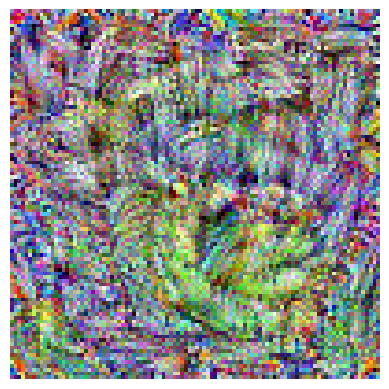

In [113]:
# visualising the above
import matplotlib.pyplot as plt
to_pil = transforms.ToPILImage()
plt.imshow(to_pil(combo_blend)); plt.axis("off")

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

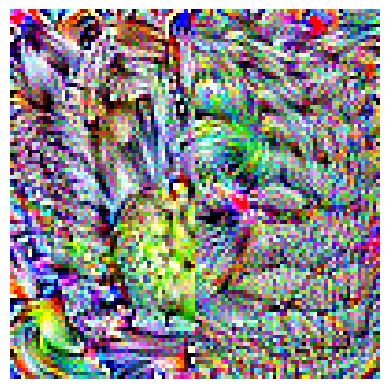

In [114]:
plt.imshow(to_pil(combo_half)); plt.axis("off")

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

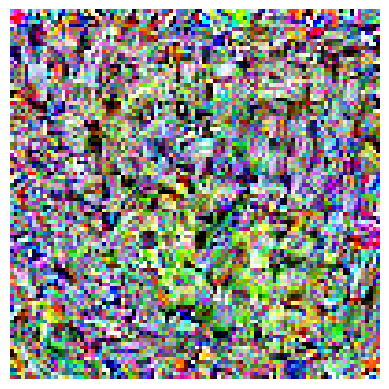

In [115]:
plt.imshow(to_pil(combo_cb)); plt.axis("off")

### Evaluating the above combinations:

In [118]:
# evaluating the combos

for name, combo in [
    ("Blend", combo_blend),
    ("Half-Half", combo_half),
    ("Checkerboard", combo_cb)
]:
    print(f"\nEvaluating {name} Combo Patch")
    evaluate_patch(model, device, backgrounds, combo, target_class, patch_size=100)
    evaluate_patch(model, device, backgrounds, combo, target_class_2, patch_size=100)



Evaluating Blend Combo Patch

Evaluating patch on 61 images

Top-1 success rate: 0.00%
Top-5 success rate: 1.64%

Evaluating patch on 61 images

Top-1 success rate: 0.00%
Top-5 success rate: 1.64%

Evaluating Half-Half Combo Patch

Evaluating patch on 61 images

Top-1 success rate: 1.64%
Top-5 success rate: 44.26%

Evaluating patch on 61 images

Top-1 success rate: 1.64%
Top-5 success rate: 13.11%

Evaluating Checkerboard Combo Patch

Evaluating patch on 61 images

Top-1 success rate: 0.00%
Top-5 success rate: 1.64%

Evaluating patch on 61 images

Top-1 success rate: 0.00%
Top-5 success rate: 0.00%


Observations: The combos mostly failed and blending made them interfere instead of combine. So multi-target patches probably need joint optimization, not post-hoc mixing.

One interesting observation is that I ran the above cell multiple times, and every time, in the case of half-half blending, the model performed slightly better while classifying the blended patch as "banana" instead of "knot"

Citation: No AI was used for the above assignment